# Exploring NSL-KDD dataset

The purpose of this notebook is a basic exploration of the NSL-KDD dataset. Here are the goals of this exploration:
* Gain a basic understanding of the data set
* Look at how the data set might be used to predict network anomalies or attacks
* Walk through some fundemental concepts of building machine learning models

Throughout we'll do some work by hand that could be done in more effective ways using delivered functionality within sci-kit. The intent here is to be more deliberate about the process of understanding what we're doing and why. We will look at how to approach some of these problems using the built-in toools in a later notebook.

In [1]:
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Welcome!')

Welcome!


# Data extraction
We'll start by fetching our data set. There's a few options for data sets here, so we'll build a couple paths and use comments to pick and choose the ones we want.

In [2]:
# fetch the training file
file_path_20_percent = '/home/furkan/instrusion_detector_learning/nsl-kdd/KDDTrain+_20Percent.txt'
file_path_full_training_set = '/home/furkan/instrusion_detector_learning/nsl-kdd/KDDTrain+.txt'
file_path_test = '/home/furkan/instrusion_detector_learning/nsl-kdd/KDDTest+.txt'

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

The data set doesn't include column names, so let's add them.

In [3]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


# Data transformations
The first transformations that we'll want to do are around the attack field. We'll start by adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack. 

In [4]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [5]:
np.shape(df)

(125972, 44)

In [6]:
set(df['protocol_type'])

{'icmp', 'tcp', 'udp'}

In [7]:
set(df['attack'])

{'back',
 'buffer_overflow',
 'ftp_write',
 'guess_passwd',
 'imap',
 'ipsweep',
 'land',
 'loadmodule',
 'multihop',
 'neptune',
 'nmap',
 'normal',
 'perl',
 'phf',
 'pod',
 'portsweep',
 'rootkit',
 'satan',
 'smurf',
 'spy',
 'teardrop',
 'warezclient',
 'warezmaster'}

In [8]:
set(df['service'])

{'IRC',
 'X11',
 'Z39_50',
 'aol',
 'auth',
 'bgp',
 'courier',
 'csnet_ns',
 'ctf',
 'daytime',
 'discard',
 'domain',
 'domain_u',
 'echo',
 'eco_i',
 'ecr_i',
 'efs',
 'exec',
 'finger',
 'ftp',
 'ftp_data',
 'gopher',
 'harvest',
 'hostnames',
 'http',
 'http_2784',
 'http_443',
 'http_8001',
 'imap4',
 'iso_tsap',
 'klogin',
 'kshell',
 'ldap',
 'link',
 'login',
 'mtp',
 'name',
 'netbios_dgm',
 'netbios_ns',
 'netbios_ssn',
 'netstat',
 'nnsp',
 'nntp',
 'ntp_u',
 'other',
 'pm_dump',
 'pop_2',
 'pop_3',
 'printer',
 'private',
 'red_i',
 'remote_job',
 'rje',
 'shell',
 'smtp',
 'sql_net',
 'ssh',
 'sunrpc',
 'supdup',
 'systat',
 'telnet',
 'tftp_u',
 'tim_i',
 'time',
 'urh_i',
 'urp_i',
 'uucp',
 'uucp_path',
 'vmnet',
 'whois'}

Next, we'll classify each of the attacks according to attack type for a more granular prediction model. 
* Denial of Service attacks:
  * apache2
  * back
  * land
  * neptune
  * mailbomb
  * pod
  * processtable
  * smurf
  * teardrop
  * udpstorm
  * worm
* Probe attacks:
  * ipsweep
  * mscan
  * nmap
  * portsweep
  * saint
  * satan
* Privilege escalation attacks
  * buffer_overflow
  * loadmdoule
  * perl
  * ps
  * rootkit
  * sqlattack
  * xterm
* Remote access attacks
  * ftp_write
  * guess_passwd
  * http_tunnel
  * imap
  * multihop
  * named
  * phf
  * sendmail
  * snmpgetattack
  * snmpguess
  * spy
  * warezclient
  * warezmaster
  * xclock
  * xsnoop

In [10]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


In [11]:
set(df['attack_map'])

{0, 1, 2, 3, 4}

In [13]:
# # get a series with the count of each flag for attack and normal traffic
# normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
# attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# # create the charts
# flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
# plt.show()

And service?

In [14]:
# # get a series with the count of each service for attack and normal traffic
# normal_services = df.loc[df.attack_flag == 0].service.value_counts()
# attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# # create the charts
# service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])        
# plt.show()


Wow! Look at how many services are in the attack set! Whereas a huge amount of normal traffic is http, our attack traffic is all over the place. That is interesting as it means that attacks are searching for many different paths into systems--some well traveled and some not. 

If we think about this from the eyes of a network adminstrator, the combination of protocol, flag and service seem like they should tell us a lot about the nature of our traffic. Coupling them with the duration of a connection and the amount of data in that connection seems like a good starting point for us.

# Feature engineering

So let's dive into some feature building. It seems like that items above would make a good place to start: protocol_type, service and flag. There's enough variation between these that we should be able to get some base level of identification. We're also going to throw in some basic numeric data: duration, src_bytes, dst_bytes. All of these are going to be readily available from modern network equipment and should tell us a lot about what is happening on our network.

In [15]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

It's worth drawing attention to a few things here. First, `pd.get_dummies` is a method that allows us to do a quick one hot encoding on our columns. This takes every value it finds in a single column and makes an individual column for each value, with a `0` or `1` indicating whether that column is 'hot'.

One thing we find is that note every value is in the test data. So that creates different shapes of our data frame. That's why we added some columns, filled them in and reorded them. We know they are all zeros because they aren't in the data.

Now let's go ahead and set our classification targets. We'l do both training sets to start: binrary and multi classifications.

In [16]:
# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

In [17]:
binary_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50388 entries, 125949 to 63270
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   protocol_type_icmp   50388 non-null  uint8
 1   protocol_type_tcp    50388 non-null  uint8
 2   protocol_type_udp    50388 non-null  uint8
 3   service_IRC          50388 non-null  uint8
 4   service_X11          50388 non-null  uint8
 5   service_Z39_50       50388 non-null  uint8
 6   service_aol          50388 non-null  uint8
 7   service_auth         50388 non-null  uint8
 8   service_bgp          50388 non-null  uint8
 9   service_courier      50388 non-null  uint8
 10  service_csnet_ns     50388 non-null  uint8
 11  service_ctf          50388 non-null  uint8
 12  service_daytime      50388 non-null  uint8
 13  service_discard      50388 non-null  uint8
 14  service_domain       50388 non-null  uint8
 15  service_domain_u     50388 non-null  uint8
 16  service_echo     

In [20]:
binary_train_X.sample(5)

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes
16841,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,8,0
116365,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,308,1248
77488,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,355,327
120109,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,400,335,10183
44267,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,516,4


# Model fitting
Based on the nature of the data we saw above, decision trees are a good starting point for building out predictive models. In this case we'll use a random forest to build and combine multiple trees. We'll start by simply taking the defaults.

In [ ]:
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9928027095681625

99% accuracy on our first try! Not bad, right? Let's see how it plays out. 

It might be interesting to see how differnt models compare against a data set like this. That is easy enought to do with `cross_val_score`. 

In [18]:
# define the list of models that we want to test
models = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=250),
    KNeighborsClassifier(),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

/home/furkan/instrusion_detector_learning/myenv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/furkan/instrusion_detector_learning/myenv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimi

<AxesSubplot:>

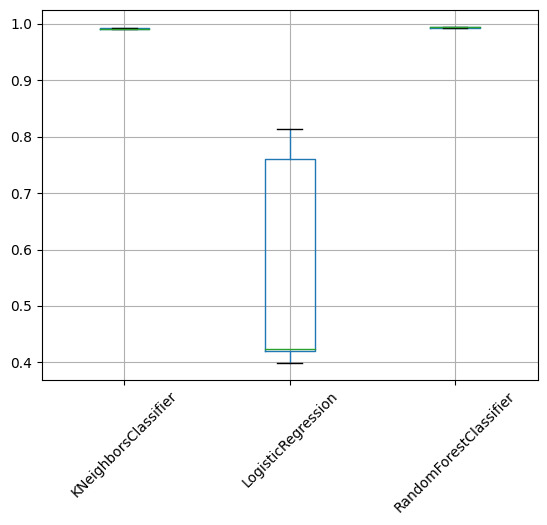

In [23]:
# a box plot will do well to show us overall performance and the variation in the models.
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

What we find is some inconsistency across the models. The random forest and K-nearest neighbors are tight groupings with solid performance. Our logistic regression didn't perform as well. That may be in  part because we didn't do sufficient preprocessing on our data to shape it into a form optimized for that model. That too is an exercise for another day.

In [24]:
# model for the mulit classification
multi_model = RandomForestClassifier()
multi_model.fit(multi_train_X, multi_train_y)
multi_predictions = multi_model.predict(multi_val_X)

# get the score
accuracy_score(multi_predictions,multi_val_y)

0.9764235817104149